<a href="https://colab.research.google.com/github/32844583/1112_ML/blob/main/Pair_Trading_with_AutoML.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install torchsummary
!pip install yfinance
!pip install pycaret
!pip install pandas-ta

In [ ]:
import os
import random
import numpy as np
import yfinance as yf
import pandas as pd
from statsmodels.tsa.stattools import adfuller
from statsmodels.regression.linear_model import OLS
import statsmodels.api as sm
from matplotlib import pyplot as plt
from datetime import timedelta
import datetime
import matplotlib.dates as mdates
from pycaret.regression import *
import pycaret
# import shap

SEED = 8
random.seed(SEED)
np.random.seed(SEED)

end_date = datetime.datetime.today()
start_date = end_date - timedelta(days=730)
start_year = start_date.year
start_month = start_date.month

In [ ]:
stock1 = '2330.TW'
stock2 = '2303.TW'
df1 = yf.download(stock1, start=start_date, end=end_date)
df2 = yf.download(stock2, start=start_date, end=end_date)

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


In [ ]:
S1 = df1.copy()
S1 = S1.drop(columns=['Close']).rename(columns={'Adj Close': 'Close'})
S2 = df2.copy()
S2 = S2.drop(columns=['Close']).rename(columns={'Adj Close': 'Close'})
S1.head()

,Open,High,Low,Close,Volume
Date,,,,,
2022-07-04,443.0,451.5,440.0,422.391418,52445919
2022-07-05,449.5,451.5,433.0,428.151276,50084244
2022-07-06,442.0,447.5,435.0,418.071472,40549763
2022-07-07,442.0,459.0,438.5,439.191071,48151202
2022-07-08,470.0,470.5,461.5,448.310852,37897895


因為日期遞增排序，所以 spread shift -1  的結果將造成每一行都是隔天的股價(預測目標是這裡的價差)

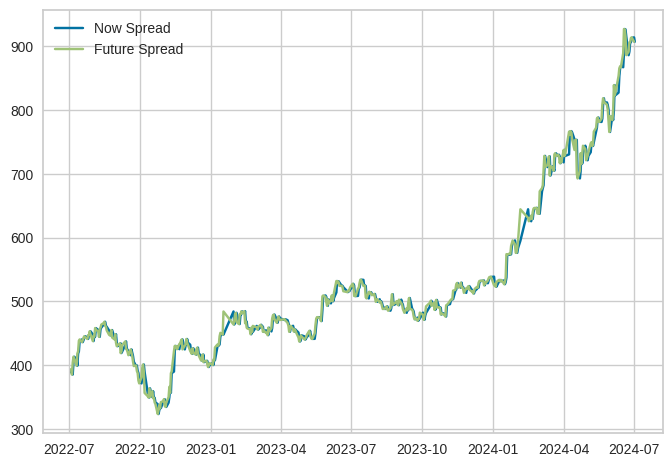

In [ ]:
NowSpread = S1['Close'] - S2['Close']
FutureSpread = NowSpread.shift(-1)
plt.plot(NowSpread, label='Now Spread')
plt.plot(FutureSpread, label='Future Spread')
plt.legend()
plt.show()

## 特徵工程

### Money Flow Index (MFI)

MFI是結合價格和成交量的動量指標，範圍0-100。

計算步驟：
1. $TP = \frac{High + Low + Close}{3}$
2. $Raw Money Flow = TP \times Volume$
3. 正/負貨幣流量：今日TP > 昨日TP為正，反之為負
4. $Money Flow Ratio = \frac{14天正貨幣流量總和}{14天負貨幣流量總和}$
5. $MFI = 100 - \frac{100}{1 + Money Flow Ratio}$

### Relative Volatility Index (RVI)

RVI測量市場波動性，範圍0-100。

計算步驟：
1. $SD = 標準差(Close, 10)$
2. $Upward/Downward SD$：根據收盤價變動判定
3. $Smoothed SD = \frac{SD + 2 \times Smoothed SD[1]}{3}$
4. $RVI = 100 \times \frac{Smoothed Upward SD}{Smoothed Upward SD + Smoothed Downward SD}$

### Chaikin Money Flow (CMF)

CMF測量買賣壓力，範圍-1到+1。

計算步驟：
1. $MFM = \frac{(Close - Low) - (High - Close)}{High - Low}$
2. $MFV = MFM \times Volume$
3. $CMF = \frac{\sum_{i=1}^{20} MFV_i}{\sum_{i=1}^{20} Volume_i}$

In [ ]:
import pandas_ta as ta

S1_MFI = ta.mfi(S1['High'], S1['Low'], S1['Close'], S1['Volume'], length=14)
S1_RVI = ta.rvi(S1['Close'], length=14)
S1_CMF = ta.cmf(S1['High'], S1['Low'], S1['Close'], S1['Volume'], length=20)

S2_MFI = ta.mfi(S2['High'], S2['Low'], S2['Close'], S2['Volume'], length=14)
S2_RVI = ta.rvi(S2['Close'], length=14)
S2_CMF = ta.cmf(S2['High'], S2['Low'], S2['Close'], S2['Volume'], length=20)

display(S1_MFI)
display(S1_RVI)
display(S1_CMF)

Date
2022-07-04          NaN
2022-07-05          NaN
2022-07-06          NaN
2022-07-07          NaN
2022-07-08          NaN
                ...    
2024-06-26    60.207927
2024-06-27    53.457638
2024-06-28    58.955199
2024-07-01    57.473571
2024-07-02    52.299500
Name: MFI_14, Length: 486, dtype: float64

Date
2022-07-04          NaN
2022-07-05          NaN
2022-07-06          NaN
2022-07-07          NaN
2022-07-08          NaN
                ...    
2024-06-26    61.960216
2024-06-27    61.960216
2024-06-28    67.327407
2024-07-01    71.170820
2024-07-02    63.681372
Name: RVI_14, Length: 486, dtype: float64

Date
2022-07-04         NaN
2022-07-05         NaN
2022-07-06         NaN
2022-07-07         NaN
2022-07-08         NaN
                ...   
2024-06-26   -0.217268
2024-06-27   -0.134902
2024-06-28   -0.055967
2024-07-01    0.034795
2024-07-02    0.020579
Name: CMF_20, Length: 486, dtype: float64

In [ ]:
CMF_GAP = S1_CMF - S2_CMF
RVI_GAP = S1_RVI - S2_RVI
MFI_GAP = S1_MFI - S2_MFI

### Money Flow Index (MFI)
- **區間**：超買 > 80 | 超賣 < 20 | 強勢 > 50 | 弱勢 < 50

### Relative Volatility Index (RVI)
- **區間**：超買 > 70 | 超賣 < 30 | 強勢 > 50 | 弱勢 < 50

### Chaikin Money Flow (CMF)
- **區間**：強勢 > 0 | 弱勢 < 0

根據以上指標定義的區間產生新的特徵
如果兩股票指標所在的區間剛好代表相反的意義，則產生訊號:
- OverSignal 為一股票超買而另一股票超賣
- StrengthSignal 為一股票強勢而另一股票弱勢

In [ ]:
def MFI_OverBuySell(x):
    if x > 80:
      return 1
    elif x < 20:
      return -1
    else:
      return 0

IndividualMFIOverSignal = pd.DataFrame({
    'S1_MFIOverSignal': S1_MFI.apply(MFI_OverBuySell),
    'S2_MFIOverSignal': S2_MFI.apply(MFI_OverBuySell)
})

def Summarize_MFI_Over(x, y):
  if x == 1 and y == -1:
    return 1
  else:
    return 0

SummaryMFIOverSignal = IndividualMFIOverSignal.apply(lambda x: Summarize_MFI_Over(x['S1_MFIOverSignal'], x['S2_MFIOverSignal']), axis=1)
# ------------------------------------------------


def RVI_OverBuySell(x):
    if x > 70:
      return 1
    elif x < 30:
      return -1
    else:
      return 0

IndividualRVIOverSignal = pd.DataFrame({
    'S1_RVIOverSignal': S1_RVI.apply(RVI_OverBuySell),
    'S2_RVIOverSignal': S2_RVI.apply(RVI_OverBuySell)
})

def Summarize_RVI_Over(x, y):
  if x == 1 and y == -1:
    return 1
  else:
    return 0

SummaryRVIOverSignal = IndividualRVIOverSignal.apply(lambda x: Summarize_RVI_Over(x['S1_RVIOverSignal'], x['S2_RVIOverSignal']), axis=1)

# ------------------------------------------------
def MFI_Strength(x):
    if x > 50:
      return 1
    else:
      return -1

IndividualMFIStrengthSignal = pd.DataFrame({
    'S1_MFIStrengthSignal': S1_MFI.apply(MFI_Strength),
    'S2_MFIStrengthSignal': S2_MFI.apply(MFI_Strength),
})

def Summarize_MFI_Strength(x, y):
  if x == 1 and y == -1:
    return 1
  else:
    return 0

SummaryMFIStrengthSignal = IndividualMFIStrengthSignal.apply(lambda x: Summarize_MFI_Strength(x['S1_MFIStrengthSignal'], x['S2_MFIStrengthSignal']), axis=1)
# ------------------------------------------------

def RVI_Strength(x):
    if x > 50:
      return 1
    else:
      return -1


IndividualRVIStrengthSignal = pd.DataFrame({
    'S1_RVIStrengthSignal': S1_RVI.apply(RVI_Strength),
    'S2_RVIStrengthSignal': S2_RVI.apply(RVI_Strength),
})

def Summarize_RVI_Strength(x, y):
  if x == 1 and y == -1:
    return 1
  else:
    return 0

SummaryRVIStrengthSignal = IndividualRVIStrengthSignal.apply(lambda x: Summarize_RVI_Strength(x['S1_RVIStrengthSignal'], x['S2_RVIStrengthSignal']), axis=1)

# ------------------------------------------------

def CMF_Strength(x):
    if x > 0:
      return 1
    else:
      return -1

IndividualCMFStrengthSignal = pd.DataFrame({
    'S1_CMFStrengthSignal': S1_CMF.apply(CMF_Strength),
    'S2_CMFStrengthSignal': S2_CMF.apply(CMF_Strength),
})

def Summarize_CMF_Strength(x, y):
  if x == 1 and y == -1:
    return 1
  else:
    return 0

SummaryCMFStrengthSignal = IndividualCMFStrengthSignal.apply(lambda x: Summarize_CMF_Strength(x['S1_CMFStrengthSignal'], x['S2_CMFStrengthSignal']), axis=1)


## 訓練資料準備


In [ ]:
train_test_data = pd.DataFrame({
    # 'NowSpread': NowSpread,
    # 'NowSpread(Lag1)': NowSpread.shift(1),
    # 'NowSpread(Lag2)': NowSpread.shift(2),
    # 'NowSpread(Lag3)': NowSpread.shift(3),
    # 'NowSpread(Lag4)': NowSpread.shift(4),
    # 'NowSpread(Lag5)': NowSpread.shift(5),
    'FutureSpread': FutureSpread,
    'MFIOver': SummaryMFIOverSignal,
    'RVIOver': SummaryRVIOverSignal,
    'MFIStrength': SummaryMFIStrengthSignal,
    'RVIStrength': SummaryRVIStrengthSignal,
    'CMFStrength': SummaryCMFStrengthSignal,
    'CMF_GAP': CMF_GAP,
    'RVI_GAP': RVI_GAP,
    'MFI_GAP': MFI_GAP,
})

train_test_data = train_test_data.dropna()
train_test_data.head()

,FutureSpread,MFIOver,RVIOver,MFIStrength,RVIStrength,CMFStrength,CMF_GAP,RVI_GAP,MFI_GAP
Date,,,,,,,,,
2022-07-29,448.233799,0,0,0,0,0,3.639875,10.043280,9.525807
2022-08-01,437.773933,0,0,0,0,0,3.635071,0.163258,2.360292
2022-08-02,446.237106,0,0,0,0,0,3.565719,3.544827,-2.022797
2022-08-03,444.658817,0,0,0,0,0,3.806361,0.717415,2.175077
2022-08-04,458.119404,0,0,0,0,0,4.102204,-6.224983,0.656138


In [ ]:
train_size = int(train_test_data.shape[0] * 0.8)
train = train_test_data.iloc[:train_size]
test = train_test_data.iloc[train_size:]

train_X = train.drop(columns=(['FutureSpread']))
test_X = test.drop(columns=(['FutureSpread']))
train_y = train['FutureSpread']
test_y = test['FutureSpread']

## 訓練模型
**PyCaret 設置說明**

- **數據分割**：80% 用於訓練
- **數據標準化**：使用魯棒（robust）標準化方法
- **多重共線性處理**：移除高度相關的特徵
- **時間序列處理**：使用時間序列交叉驗證策略
- **特徵工程**：啟用多項式特徵
- **異常值處理**：移除異常值


參考資料
- [Regression by PyCaret](https://www.kaggle.com/code/abedi756/regression-by-pycaret#notebook-container)
- [PyCaret Introduction: Classification & Regression](https://www.kaggle.com/code/frtgnn/pycaret-introduction-classification-regression)
- [Avocado Price Regression w/ PyCaret & EDA](https://www.kaggle.com/code/caesarmario/avocado-price-regression-w-pycaret-eda#8.-|-PyCaret-Setup-%E2%9A%99)


In [ ]:
claude = setup(data=train,
      target='FutureSpread',
      train_size=0.8,
      normalize=True,
      normalize_method='robust',
      # remove_multicollinearity=True,
      # multicollinearity_threshold=0.7,
      polynomial_features=True,
      fold_strategy='timeseries',
      fold=5,
      data_split_shuffle=False,
      fold_shuffle=False,
      session_id=123)

,Description,Value
0,Session id,123
1,Target,FutureSpread
2,Target type,Regression
3,Original data shape,"(372, 9)"
4,Transformed data shape,"(372, 45)"
5,Transformed train set shape,"(297, 45)"
6,Transformed test set shape,"(75, 45)"
7,Numeric features,8
8,Preprocess,True
9,Imputation type,simple


交叉驗證


In [ ]:
best_model = compare_models(fold=5)

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
et,Extra Trees Regressor,44.9149,2921.9616,52.3123,-12.6064,0.1195,0.0994,0.2180
gbr,Gradient Boosting Regressor,44.7265,2925.5361,52.9383,-14.1765,0.1210,0.0991,0.1580
dt,Decision Tree Regressor,45.7757,3248.4030,55.6035,-15.1481,0.1295,0.1021,0.0600
ada,AdaBoost Regressor,45.6497,2934.3105,52.5843,-15.2358,0.1203,0.0999,0.1440
rf,Random Forest Regressor,45.4772,3095.7610,54.0065,-15.3608,0.1243,0.1002,0.2940
lightgbm,Light Gradient Boosting Machine,46.4577,3097.6387,54.6598,-16.3362,0.1258,0.1019,0.5280
xgboost,Extreme Gradient Boosting,45.4985,3085.6551,54.1388,-16.4170,0.1248,0.1004,0.1900
omp,Orthogonal Matching Pursuit,51.1978,3827.7249,58.0776,-16.7001,0.1323,0.1148,0.0960
dummy,Dummy Regressor,48.7263,3145.5886,53.9074,-17.0643,0.1217,0.1057,0.0940
knn,K Neighbors Regressor,48.3933,3097.0579,54.4696,-17.8201,0.1245,0.1055,0.0620


Processing:   0%|          | 0/81 [00:00<?, ?it/s]

`n_iter` 參數
- **`n_iter=50`**: 這個參數設定了在模型調整過程中隨機搜尋的迭代次數。這意味著演算法將測試 50 種不同的超參數組合，來嘗試找出能夠最佳化目標函數（這裡是 MAE，即平均絕對誤差）的最佳組合。
- **隨機搜尋**: 通常，`tune_model` 函數可以採用不同的搜尋策略，例如網格搜尋或隨機搜尋。在 PyCaret 中，預設採用隨機搜尋策略，這是一種有效率且常用的方法，透過隨機選擇參數組合來探索參數空間，特別適用於參數空間大或當迭代次數有限時。

In [ ]:
best_model = create_model('lasso')

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,60.8881,5538.6963,74.4224,-2.3579,0.1874,0.1679
1,66.1245,5990.1060,77.3958,-7.3908,0.1891,0.1438
2,21.3540,681.1385,26.0986,-1.5869,0.0571,0.0456
3,65.3342,4764.6714,69.0266,-38.8887,0.1462,0.1270
4,73.8338,6268.4043,79.1733,-66.7818,0.1792,0.1505
Mean,57.5069,4648.6033,65.2233,-23.4012,0.1518,0.1270
Std,18.5503,2047.9208,19.8625,25.6778,0.0498,0.0427


Processing:   0%|          | 0/4 [00:00<?, ?it/s]

In [ ]:
tuned_model = tune_model(best_model, n_iter=50, optimize = 'MAE')

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,40.3685,2855.0857,53.4330,-0.7309,0.1388,0.1137
1,49.4136,3098.0459,55.6601,-3.3397,0.1301,0.1079
2,20.4132,648.4048,25.4638,-1.4626,0.0556,0.0434
3,72.8874,5537.8872,74.4170,-45.3619,0.1565,0.1416
4,58.4378,3708.7925,60.8999,-39.1041,0.1328,0.1190
Mean,48.3041,3169.6432,53.9747,-17.9998,0.1228,0.1051
Std,17.6019,1572.2581,16.0116,19.9032,0.0348,0.0329


Processing:   0%|          | 0/7 [00:00<?, ?it/s]

Fitting 5 folds for each of 50 candidates, totalling 250 fits


In [ ]:
tuned_model

Lasso(alpha=6.2, random_state=123)

In [ ]:
evaluate_model(tuned_model)

interactive(children=(ToggleButtons(description='Plot Type:', icons=('',), options=(('Pipeline Plot', 'pipelin…

In [ ]:
prediciton = predict_model(tuned_model)
prediciton

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Lasso Regression,65.8634,5013.6333,70.8070,-5.1557,0.1415,0.1231


,MFIOver,RVIOver,MFIStrength,RVIStrength,CMFStrength,CMF_GAP,RVI_GAP,MFI_GAP,FutureSpread,prediction_label
Date,,,,,,,,,,
2023-10-20,0,0,0,0,0,3.042358,-0.553253,-14.931136,490.544891,452.655365
2023-10-23,0,0,0,0,0,3.178770,3.208711,-15.515169,490.829071,452.285400
2023-10-24,0,0,0,1,0,2.959002,13.110441,-13.249032,490.118622,407.891602
2023-10-25,0,0,0,0,0,2.783784,3.830680,-12.208016,479.427277,454.193024
2023-10-26,0,0,0,1,0,2.980717,3.379103,-8.526979,481.589417,429.915924
...,...,...,...,...,...,...,...,...,...,...
2024-01-29,0,0,1,1,0,5.021759,40.636295,33.841175,589.570984,509.959442
2024-01-30,0,0,1,0,0,5.366595,13.264087,26.992548,576.258057,455.108368
2024-01-31,0,0,1,1,0,5.504446,8.459973,22.250109,576.210693,513.386292


In [ ]:
# !pip install ydata-profiling

In [ ]:
# from ydata_profiling import ProfileReport
# profile = ProfileReport(train_test_data, title="Trending Books")
# profile.to_notebook_iframe()
# profile.to_file("books_data.html")

**資料前處理解釋**
對於資料 `x` 和 `y` 進行處理，具體步驟如下：

**處理步驟**
1. **去除資料：**
   - `x` 資料：刪去前20筆 (0-19) 以及最後一筆。
   - `y` 資料：同樣去頭去尾，理由是訓練集中的最後一筆資料不存在對應的 `target_spread`（`y` 值為 nan）。

2. **處理原因：**
   - 第一筆資料通常是空的 (`nan`)，之後再數19筆（原始的第21筆存在真正的值），這是因為使用滾動平均或其他滾動計算時，會跳過 `nan` 的資料。

**附註**
- `loc`: 用於選擇數據，包含指定的頭尾索引。
- `iloc`: 用於選擇數據，基於位置，從0開始計數。
- `pd.DataFrame({column_name: pd.Series})`: 是按照索引進行合併


In [ ]:
# !pip install shap

In [ ]:
# train_size = int(train_test_data.shape[0] * 0.8)
# test_X = train_test_data.drop(columns=['TargetSpread'])[train_size:]
# explainer = shap.Explainer(tuned_model.predict, test_X)
# shap_values = explainer(test_X)
# shap.plots.bar(shap_values)
# shap.summary_plot(shap_values)

策略:
如果預測價差變化比當前價差大3%，則做多股票一放空股票二，反之亦然，在3%內則不持有任何股票

In [ ]:
TestPred = predict_model(tuned_model, data=test_X)['prediction_label']
Stock1Return = (S1['Close'].shift(-1) - S1['Close']) / S1['Close'] * 100
Stock2Return = (S2['Close'].shift(-1) - S2['Close']) / S2['Close'] * 100
ResultData = pd.concat([TestPred, Stock1Return, Stock2Return, NowSpread, FutureSpread], axis=1)
ResultData.columns = ['Prediction', 'Stock1Return', 'Stock2Return', 'NowSpread', 'FutureSpread']

In [ ]:
ResultData['SpreadDelta'] = (ResultData['Prediction'] - ResultData['NowSpread']) / ResultData['NowSpread']

ResultData['Stock1Pos'] = 0
ResultData['Stock2Pos'] = 0

for i in range(1, len(ResultData)):
    if ResultData['SpreadDelta'].iloc[i] < -0.03 and ResultData['Stock1Pos'].iloc[i-1] == 0:
        ResultData['Stock1Pos'].iloc[i] = -1
        ResultData['Stock2Pos'].iloc[i] = 1
    elif ResultData['SpreadDelta'].iloc[i] > 0.03 and ResultData['Stock2Pos'].iloc[i-1] == 0:
        ResultData['Stock1Pos'].iloc[i] = 1
        ResultData['Stock2Pos'].iloc[i] = -1
    elif abs(ResultData['SpreadDelta'].iloc[i]) < 0.03:
        ResultData['Stock1Pos'].iloc[i] = 0
        ResultData['Stock2Pos'].iloc[i] = 0
    else:
        ResultData['Stock1Pos'].iloc[i] = ResultData['Stock1Pos'].iloc[i-1]
        ResultData['Stock2Pos'].iloc[i] = ResultData['Stock2Pos'].iloc[i-1]

ResultData['TotalReturn'] = (ResultData['Stock1Return'].shift(-1) * ResultData['Stock1Pos'] / 100 +
                             ResultData['Stock2Return'].shift(-1) * ResultData['Stock2Pos'] / 100 + 1)

ResultData['CumReturn'] = ResultData['TotalReturn'].cumprod()

ResultData = ResultData.dropna()

In [ ]:
ResultData

,Prediction,Stock1Return,Stock2Return,NowSpread,FutureSpread,SpreadDelta,Stock1Pos,Stock2Pos,TotalReturn,CumReturn
Date,,,,,,,,,,
2024-02-05,511.052246,7.894745,2.286908,594.957981,644.483543,-0.141028,-1,1,1.012972,1.012972
2024-02-15,514.333618,-2.008609,-0.711384,644.483543,630.933804,-0.201945,-1,1,1.013462,1.026609
2024-02-16,485.651215,-0.732062,0.614128,630.933804,625.692039,-0.230266,-1,1,0.988760,1.015070
2024-02-19,479.559875,1.327428,0.203457,625.692039,634.520958,-0.233553,-1,1,0.993505,1.008477
2024-02-20,455.402618,-0.873368,-1.522838,634.520958,629.282253,-0.282289,-1,1,0.985909,0.994267
...,...,...,...,...,...,...,...,...,...,...
2024-06-24,457.102417,0.531915,-0.704219,886.194847,891.573753,-0.484196,-1,1,0.987673,0.808774
2024-06-25,435.452332,1.587302,0.354607,891.573753,906.384300,-0.511591,-1,1,0.996466,0.805917
2024-06-26,454.519867,0.000000,-0.353354,906.384300,906.573753,-0.498535,-1,1,0.981339,0.790877


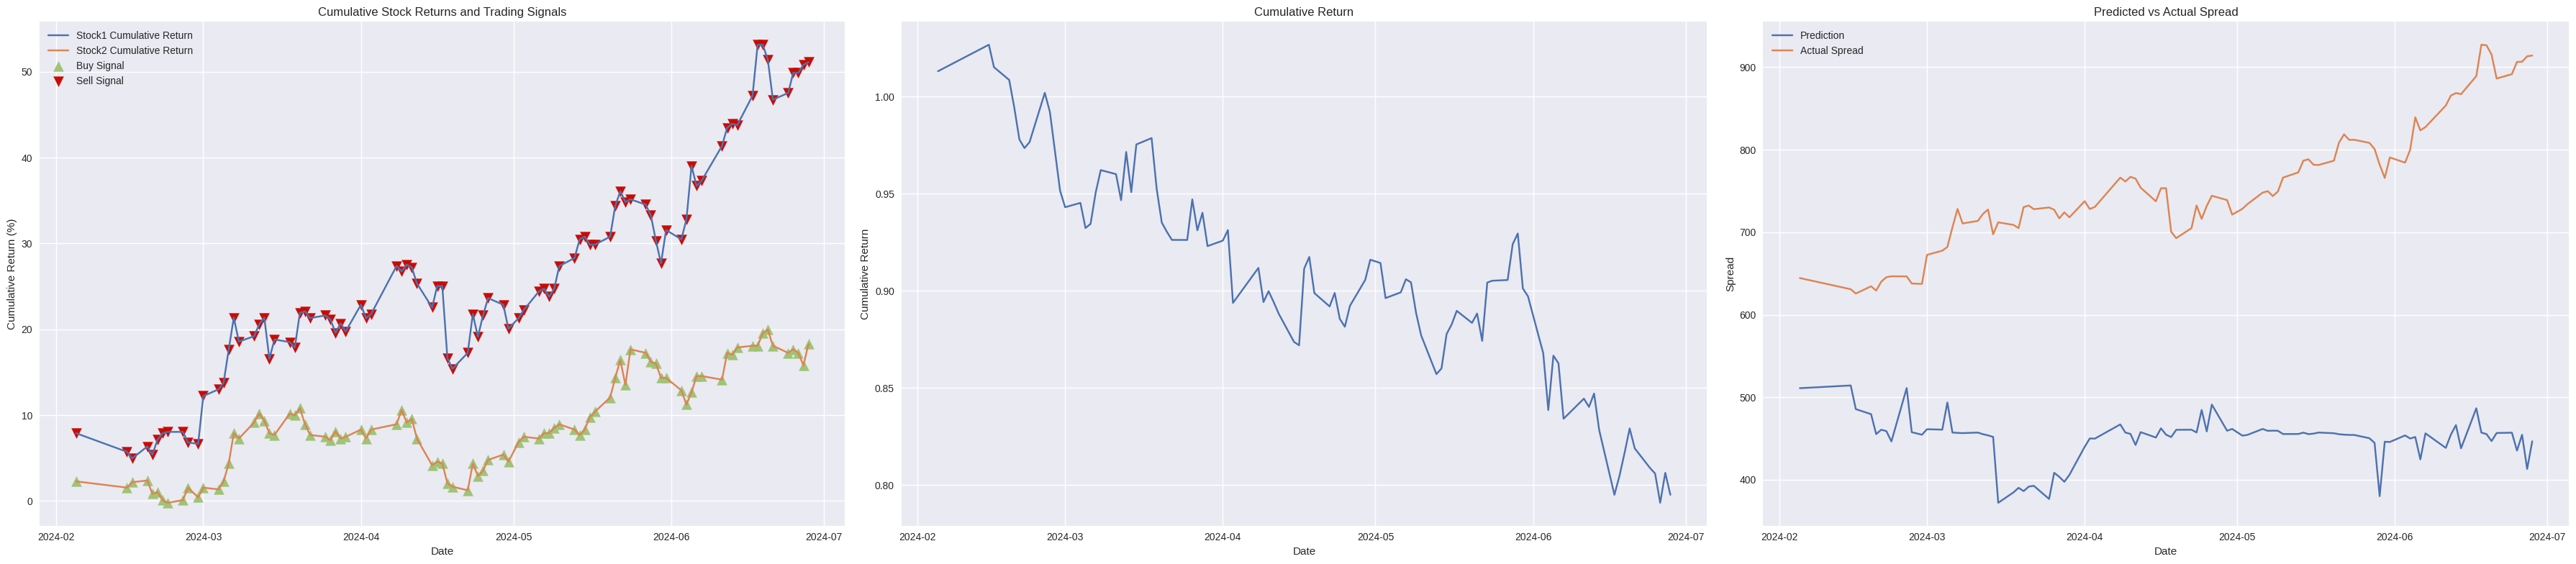

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# 計算累積收益
ResultData['Stock1CumReturn'] = (1 + ResultData['Stock1Return'] / 100).cumprod() - 1
ResultData['Stock2CumReturn'] = (1 + ResultData['Stock2Return'] / 100).cumprod() - 1

# 設置圖表風格
plt.style.use('seaborn')
sns.set_palette("deep")

# 創建一個 3x1 的子圖
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(36, 8))

# 圖表一：股票一與股票二的累積收益變化折線圖
ax1.plot(ResultData.index, ResultData['Stock1CumReturn'] * 100, label='Stock1 Cumulative Return')
ax1.plot(ResultData.index, ResultData['Stock2CumReturn'] * 100, label='Stock2 Cumulative Return')

# 添加買賣訊號
buy_signals1 = ResultData[ResultData['Stock1Pos'] == 1].index
sell_signals1 = ResultData[ResultData['Stock1Pos'] == -1].index
buy_signals2 = ResultData[ResultData['Stock2Pos'] == 1].index
sell_signals2 = ResultData[ResultData['Stock2Pos'] == -1].index

ax1.scatter(buy_signals1, ResultData.loc[buy_signals1, 'Stock1CumReturn'] * 100, marker='^', color='g', s=100, label='Buy Signal')
ax1.scatter(sell_signals1, ResultData.loc[sell_signals1, 'Stock1CumReturn'] * 100, marker='v', color='r', s=100, label='Sell Signal')
ax1.scatter(buy_signals2, ResultData.loc[buy_signals2, 'Stock2CumReturn'] * 100, marker='^', color='g', s=100)
ax1.scatter(sell_signals2, ResultData.loc[sell_signals2, 'Stock2CumReturn'] * 100, marker='v', color='r', s=100)

ax1.set_title('Cumulative Stock Returns and Trading Signals')
ax1.set_xlabel('Date')
ax1.set_ylabel('Cumulative Return (%)')
ax1.legend()
# 圖表二：CumReturn 的收益圖
ax2.plot(ResultData.index, ResultData['CumReturn'])
ax2.set_title('Cumulative Return')
ax2.set_xlabel('Date')
ax2.set_ylabel('Cumulative Return')

# 圖表三：預測(Prediction)與現實(FutureSpread)的折線圖
ax3.plot(ResultData.index, ResultData['Prediction'], label='Prediction')
ax3.plot(ResultData.index, ResultData['FutureSpread'], label='Actual Spread')
ax3.set_title('Predicted vs Actual Spread')
ax3.set_xlabel('Date')
ax3.set_ylabel('Spread')
ax3.legend()

# 調整子圖之間的間距
plt.tight_layout()

# 顯示圖表
plt.show()